In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import joblib

Data Preparation

In [2]:
data = pd.read_csv('customer_churn.csv')

In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
data.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [6]:
data.isna().sum()


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
data.eq(' ').sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [8]:
data.shape

(7043, 21)

In [9]:
#since totalcharges is a string we convert it to numeric and also drop customer id
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.fillna({'TotalCharges': data['TotalCharges'].median()}, inplace=True)
data.drop(['customerID'], axis=1, inplace=True)

In [10]:
data.eq(' ').sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [11]:
data.shape

(7043, 20)

In [12]:
data.duplicated().sum()

22

In [13]:
#identifying the columns for categorical and numerical data
categorical_cols = data.select_dtypes(include=['object']).columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']

In [14]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [15]:
data[categorical_cols].describe()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


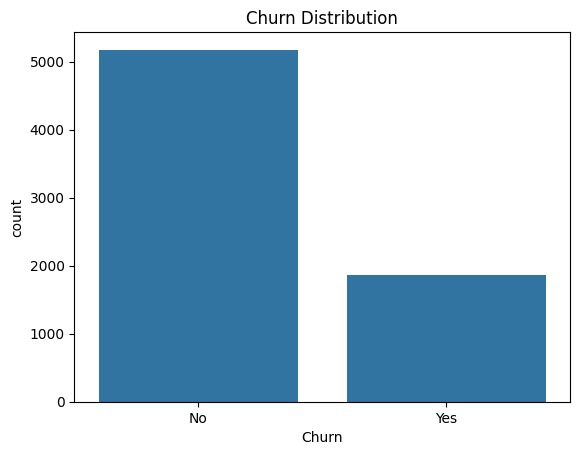

In [16]:
sns.countplot(x='Churn', data=data)
plt.title("Churn Distribution")
plt.show()

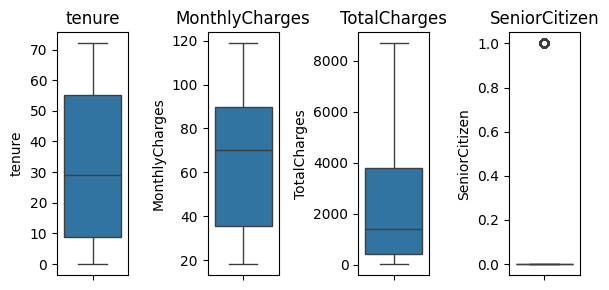

In [17]:
# creating a boxplot with each numerical column to check for outliers
plt.figure(figsize=(6, 3))

for i in range(0, len(numerical_cols)):
    plt.subplot(1, len(numerical_cols), i + 1)  
    sns.boxplot(y=data[numerical_cols[i]])
    plt.title(numerical_cols[i])

plt.tight_layout()
plt.show()

C:\Users\aadit\AppData\Local\Temp\ipykernel_21016\3602347861.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=variable, ax=ax, palette='crest')
C:\Users\aadit\AppData\Local\Temp\ipykernel_21016\3602347861.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=variable, ax=ax, palette='crest')
C:\Users\aadit\AppData\Local\Temp\ipykernel_21016\3602347861.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=variable, ax=ax, palette='crest')
C:\Users\aadit\AppData\Local\Temp\ipykernel_21016\3602347861.

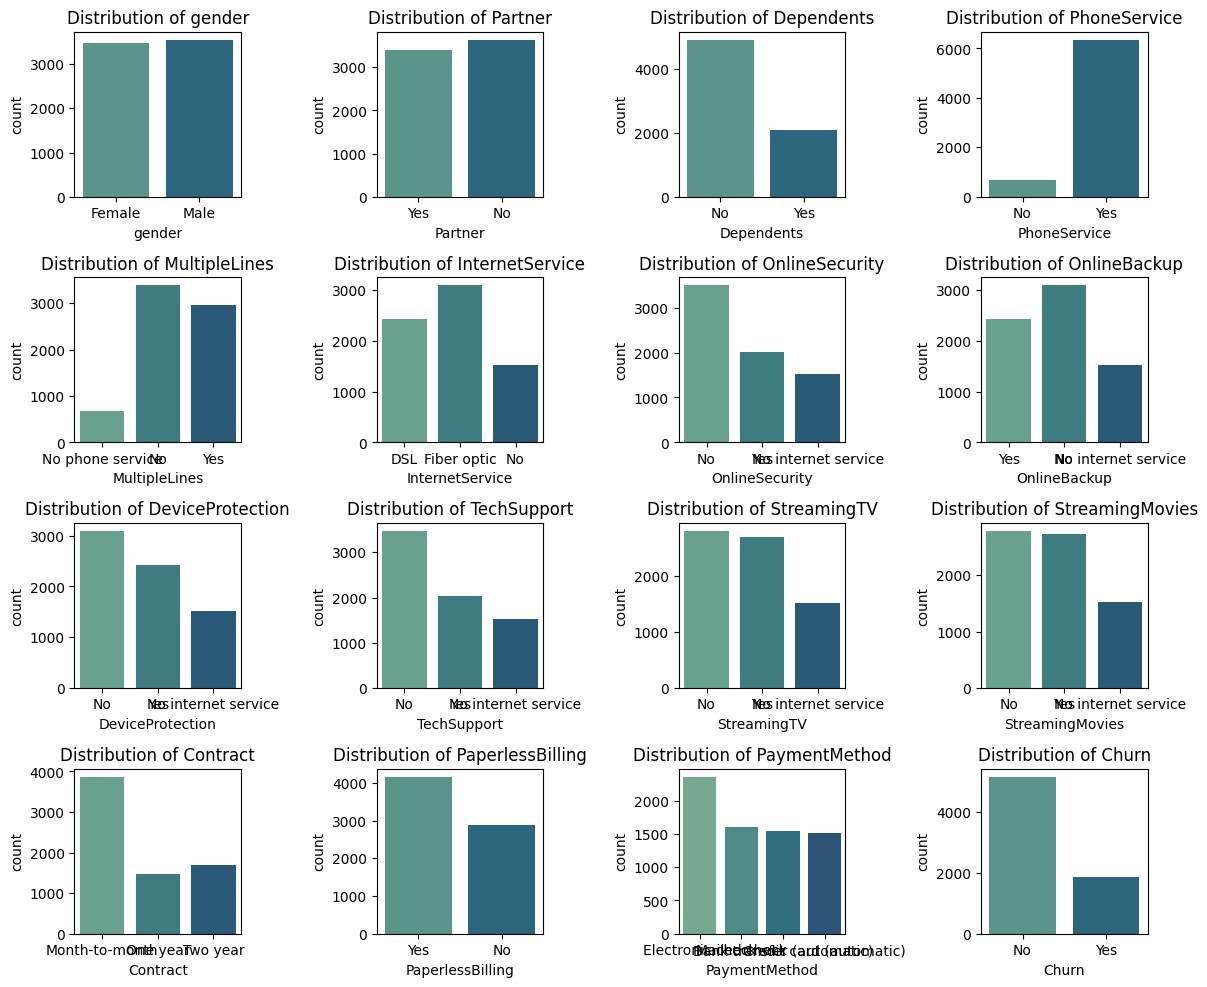

In [18]:
#we create count plots for each categorical column to visualize the distribution of categories within each variable.
plt.figure(figsize=(12, 12))
for n, variable in enumerate(categorical_cols):
    ax = plt.subplot(5, 4, n + 1)  
    sns.countplot(data=data, x=variable, ax=ax, palette='crest')
    ax.set_title(f"Distribution of {variable}")
plt.tight_layout()  
plt.show()


In [19]:
# one-hot encoding for categorical features
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [20]:
data.shape

(7043, 31)

In [21]:
scaler = StandardScaler()

data['MonthlyCharges'] = scaler.fit_transform(data[['MonthlyCharges']])
data['TotalCharges'] = scaler.fit_transform(data[['TotalCharges']])


In [22]:
data

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,-1.160323,-0.994242,False,True,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False
1,0,34,-0.259629,-0.173244,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
2,0,2,-0.362660,-0.959674,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,True
3,0,45,-0.746535,-0.194766,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
4,0,2,0.197365,-0.940470,False,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,0.665992,-0.128655,True,True,True,True,False,True,...,True,False,True,True,False,True,False,False,True,False
7039,0,72,1.277533,2.243151,False,True,True,True,False,True,...,True,False,True,True,False,True,True,False,False,False
7040,0,11,-1.168632,-0.854469,False,True,True,False,True,False,...,False,False,False,False,False,True,False,True,False,False
7041,1,4,0.320338,-0.872062,True,True,False,True,False,True,...,False,False,False,False,False,True,False,False,True,True


Feature Selection and Engineering:

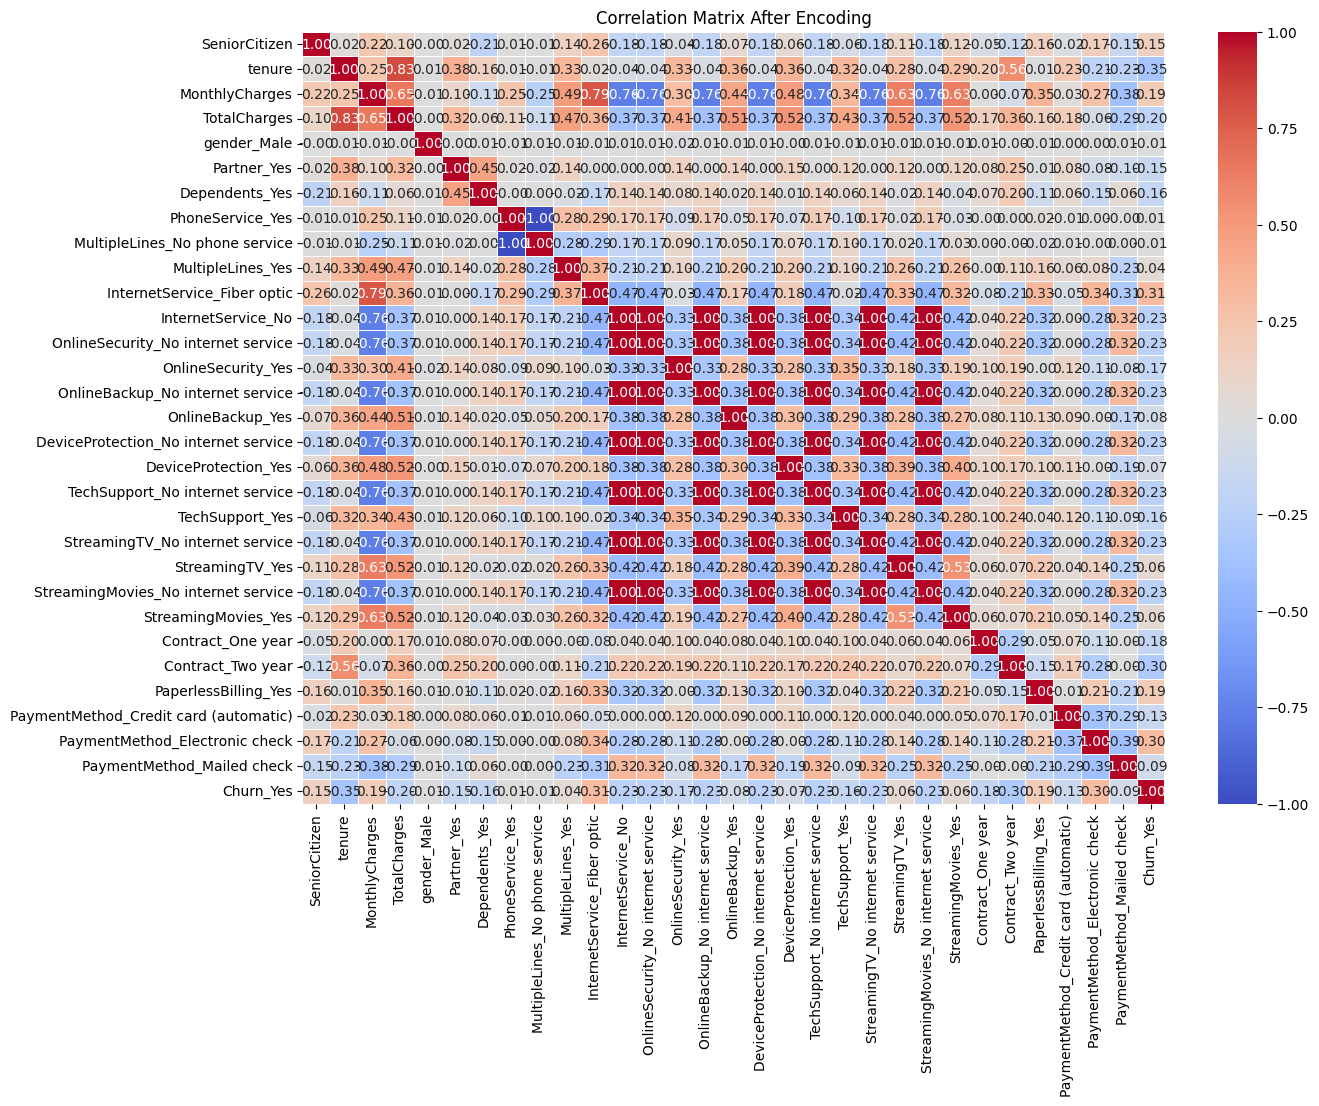

In [23]:
# we compute the correlation matrix of the numerical columns to see the relationships between variables using a heatmap.
correlation_matrix = data.corr()

plt.figure(figsize=(14, 11))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.tight_layout()
plt.title("Correlation Matrix After Encoding")
plt.show()

In [24]:
#dropping columns with more than 0.9 correlation

data = data.drop(columns=['MultipleLines_No phone service',
 'OnlineSecurity_No internet service',
 'OnlineBackup_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service'])

In [25]:
data.shape

(7043, 24)

Model Building and Evaluation

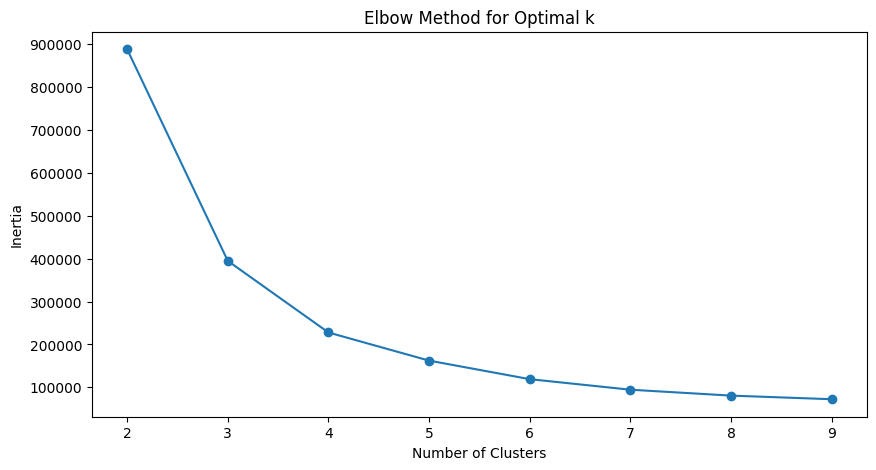

K-Means Inertia: 887908.22
K-Means Silhouette Score: 0.66
Cluster Distribution:
KMeans_Cluster
1    3904
0    3139
Name: count, dtype: int64


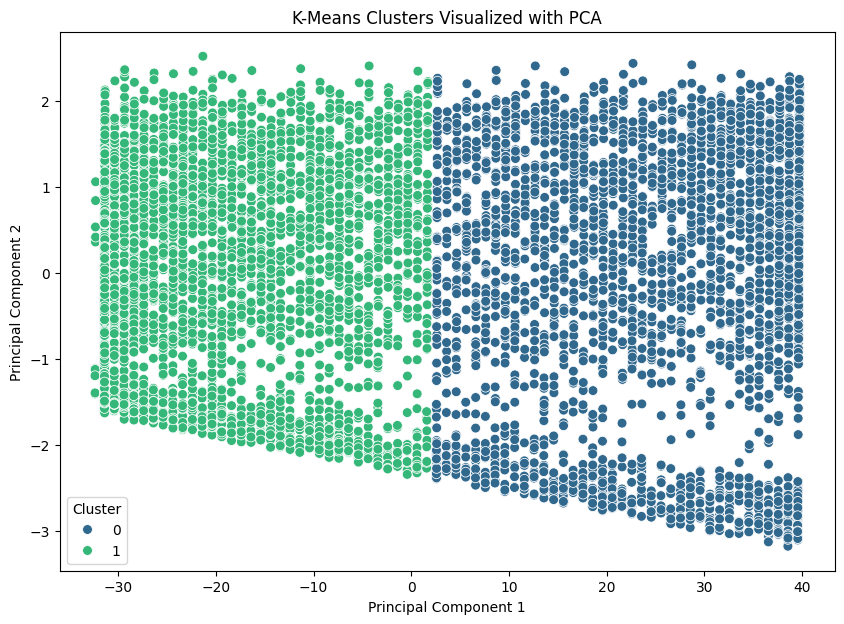

Cluster vs Churn Analysis:
Churn_Yes          False     True 
KMeans_Cluster                    
0               0.877987  0.122013
1               0.619365  0.380635


In [26]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

X = data.drop('Churn_Yes', axis=1)  # Exclude the target variable for clustering

# Elbow Method for Optimal k
distortions = []
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), distortions, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Choose the optimal number of clusters
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

data['KMeans_Cluster'] = kmeans.labels_
inertia = kmeans.inertia_
silhouette_avg = silhouette_score(X, kmeans.labels_)

print(f"K-Means Inertia: {inertia:.2f}")
print(f"K-Means Silhouette Score: {silhouette_avg:.2f}")
print(f"Cluster Distribution:\n{data['KMeans_Cluster'].value_counts()}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['KMeans_Cluster'], palette='viridis', s=50)
plt.title("K-Means Clusters Visualized with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

# Cluster vs Churn Analysis
cluster_churn_analysis = pd.crosstab(data['KMeans_Cluster'], data['Churn_Yes'], normalize='index')
print("Cluster vs Churn Analysis:")
print(cluster_churn_analysis)


In [27]:
# Splitting the dataset
X = data.drop('Churn_Yes', axis=1)  # features
y = data['Churn_Yes']  # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
#setting hyperparameters
dtree_param_grid = {
    'criterion': ['gini', 'entropy'],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'class_weight': ['balanced']      
}

dtree = DecisionTreeClassifier(random_state=42)

#keeping cv as 5 and scoring as F1
grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=dtree_param_grid,
    scoring='f1',
    cv=5,
    verbose=2,
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

best_dtree = grid_search.best_estimator_

dtree_pred = best_dtree.predict(X_test)

dtree_accuracy = accuracy_score(y_test, dtree_pred)
dtree_roc_auc = roc_auc_score(y_test, best_dtree.predict_proba(X_test)[:, 1])
dtree_precision = precision_score(y_test, dtree_pred)
dtree_recall = recall_score(y_test, dtree_pred)
dtree_f1 = f1_score(y_test, dtree_pred)

#printing the metrics
print(f"\nDecision Tree Metrics:")
print(f"  Accuracy: {dtree_accuracy:.2f}")
print(f"  Precision: {dtree_precision:.2f}")
print(f"  Recall: {dtree_recall:.2f}")
print(f"  F1-Score: {dtree_f1:.2f}")
print(f"  AUC-ROC: {dtree_roc_auc:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, dtree_pred))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END class_weight=balanced, criterion=gini, max_depth=None, min_samples_split=2; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=None, min_samples_split=2; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=None, min_samples_split=2; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=None, min_samples_split=2; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=None, min_samples_split=2; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=None, min_samples_split=5; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=None, min_samples_split=5; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=None, min_samples_split=5; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=None, min_samples_split=5; total time=   0.0s
[C

In [29]:
#setting hyperparameters
rf_param_grid = {
    'n_estimators': [15, 25],  
    'max_depth': [None, 3, 5, 7],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']  
}

rf = RandomForestClassifier(random_state=42)

#keeping cv as 5 and scoring F1
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1  
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_

rf_pred = best_rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

#printing the metrics
print(f"\nRandom Forest Metrics:")
print(f"  Accuracy: {rf_accuracy:.2f}")
print(f"  Precision: {rf_precision:.2f}")
print(f"  Recall: {rf_recall:.2f}")
print(f"  F1-Score: {rf_f1:.2f}")
print(f"  AUC-ROC: {rf_roc_auc:.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, rf_pred)}")

print("\nClassification Report:")
print(classification_report(y_test, rf_pred))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 25}

Random Forest Metrics:
  Accuracy: 0.76
  Precision: 0.53
  Recall: 0.83
  F1-Score: 0.65
  AUC-ROC: 0.86
Confusion Matrix:
[[764 272]
 [ 62 311]]

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.74      0.82      1036
        True       0.53      0.83      0.65       373

    accuracy                           0.76      1409
   macro avg       0.73      0.79      0.74      1409
weighted avg       0.82      0.76      0.78      1409



In [30]:
#setting hyperparameters
mlp_param_grid = {
    'hidden_layer_sizes': [              
        (100, 50, 25),
        (100, 50, 25, 10)],
    'activation': ['tanh', 'relu'], 
    'solver': ['adam', 'sgd',],
    'max_iter': [200, 300],
}

mlp = MLPClassifier(random_state=42)

#keeping cv as 5 and scoring F1
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=mlp_param_grid,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1  
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

best_mlp = grid_search.best_estimator_

mlp_pred = best_mlp.predict(X_test)

mlp_accuracy = accuracy_score(y_test, mlp_pred)
mlp_roc_auc = roc_auc_score(y_test, best_mlp.predict_proba(X_test)[:, 1])
mlp_f1 = f1_score(y_test, mlp_pred)
mlp_precision = precision_score(y_test, mlp_pred)
mlp_recall = recall_score(y_test, mlp_pred)

#printing the metrics
print(f"\nNeural Network Metrics:")
print(f"  Accuracy: {mlp_accuracy:.2f}")
print(f"  AUC-ROC: {mlp_roc_auc:.2f}")
print(f"  F1-Score: {mlp_f1:.2f}")
print(f"  Precision: {mlp_precision:.2f}")
print(f"  Recall: {mlp_recall:.2f}")

print("\nClassification Report:\n", classification_report(y_test, mlp_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 25), 'max_iter': 300, 'solver': 'sgd'}

Neural Network Metrics:
  Accuracy: 0.81
  AUC-ROC: 0.86
  F1-Score: 0.62
  Precision: 0.65
  Recall: 0.60

Classification Report:
               precision    recall  f1-score   support

       False       0.86      0.88      0.87      1036
        True       0.65      0.60      0.62       373

    accuracy                           0.81      1409
   macro avg       0.76      0.74      0.75      1409
weighted avg       0.80      0.81      0.81      1409



In [31]:
#setting hyperparameters
svm_param_grid = {
    'C': [0.1, 1, 10],  
    'kernel': ['rbf','poly'], 
    'gamma': ['scale'], 
    'class_weight':['balanced']
}

svm = SVC(probability=True)

#keeping cv as 5 and scoring F1
grid_search = GridSearchCV(svm, svm_param_grid, cv=5, scoring='f1', verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

best_svm = grid_search.best_estimator_

svm_pred = best_svm.predict(X_test)

svm_accuracy = accuracy_score(y_test, svm_pred)
svm_roc_auc = roc_auc_score(y_test, best_svm.predict_proba(X_test)[:, 1])
svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)

#printing the metrics
print("\nSupport Vector Machine Metrics:")
print(f"  Accuracy: {svm_accuracy:.2f}")
print(f"  Precision: {svm_precision:.2f}")
print(f"  Recall: {svm_recall:.2f}")
print(f"  F1-Score: {svm_f1:.2f}")
print(f"  AUC-ROC: {svm_roc_auc:.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, svm_pred)}")

print("\nClassification Report:")
print(classification_report(y_test, svm_pred))

svm_conf_matrix = confusion_matrix(y_test, svm_pred)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=   4.3s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=   4.3s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=   4.2s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=   4.2s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=   4.3s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=poly; total time=   2.7s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=poly; total time=   2.8s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=poly; total time=   2.6s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=poly; total time=   2.6s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=poly; total time=   2.7s
[CV] END C=1, class_weight=balanced, gamma=scale, kernel=rbf; total time=   4.1s
[CV] END C=1, class_weig

In [32]:
#setting hyperparameters
param_grid = {
    'C': [1, 10, 100, 200], 
    'max_iter': [200, 300, 500],  
    'l1_ratio': [0.0, 0.02],
    'class_weight': ['balanced'] 
}

#keeping cv as 5 and scoring F1
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1')

grid_search.fit(X_train, y_train)

best_log_reg_model = grid_search.best_estimator_
best_params = grid_search.best_params_

best_log_reg_pred = best_log_reg_model.predict(X_test)

accuracy = accuracy_score(y_test, best_log_reg_pred)
roc_auc = roc_auc_score(y_test, best_log_reg_model.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, best_log_reg_pred)
precision = precision_score(y_test, best_log_reg_pred)
recall = recall_score(y_test, best_log_reg_pred)

#printing the metrics
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, best_log_reg_pred)}")

print("\nClassification Report:")
print(classification_report(y_test, best_log_reg_pred))


c:\Users\aadit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\aadit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\aadit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\aad

Best Hyperparameters: {'C': 100, 'class_weight': 'balanced', 'l1_ratio': 0.0, 'max_iter': 300}
Accuracy: 0.75
AUC-ROC: 0.86
F1-Score: 0.64
Precision: 0.52
Recall: 0.83
Confusion Matrix:
[[749 287]
 [ 64 309]]

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.72      0.81      1036
        True       0.52      0.83      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.78      0.72      1409
weighted avg       0.81      0.75      0.76      1409

